In [6]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.16.1


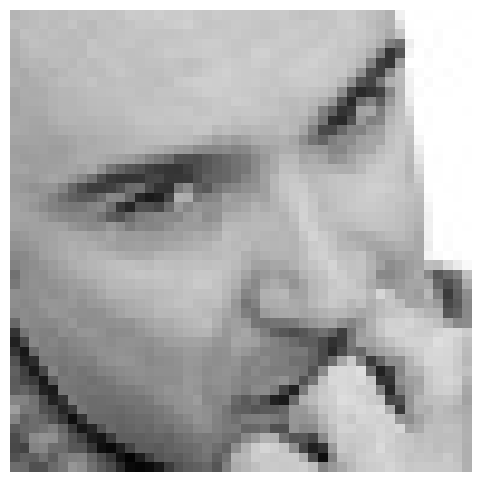

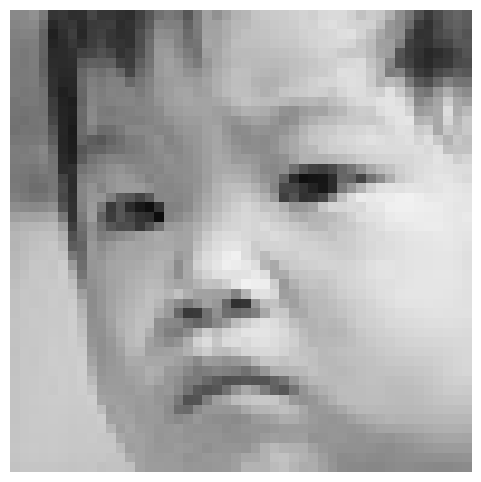

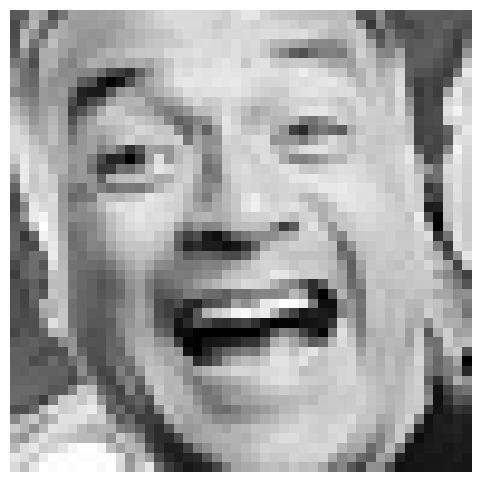

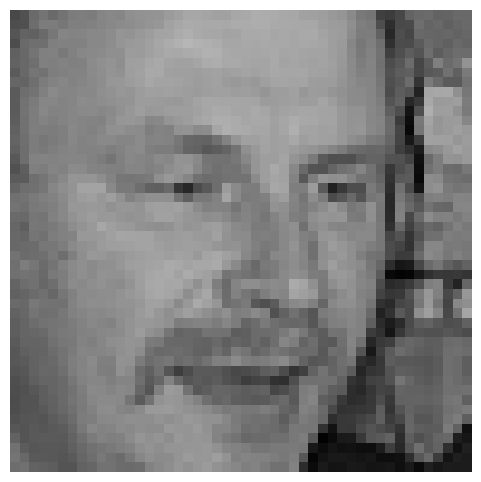

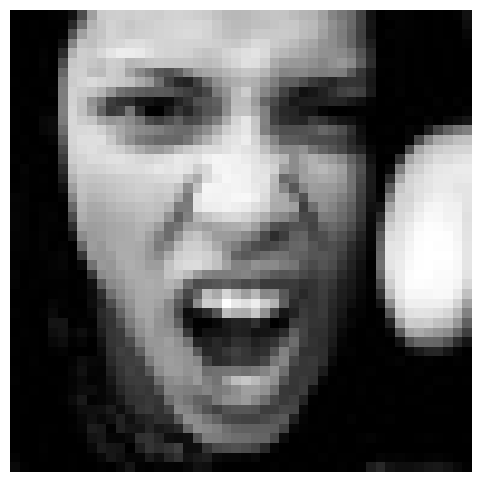

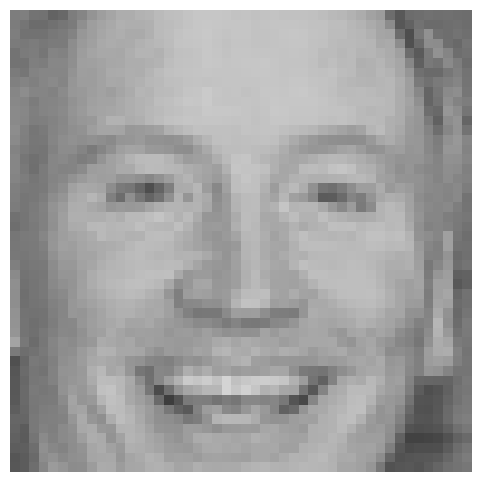

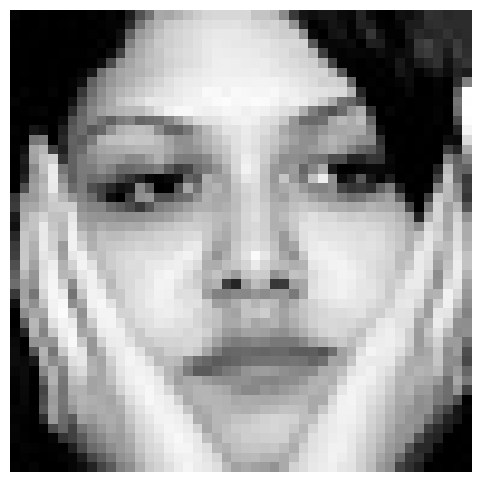

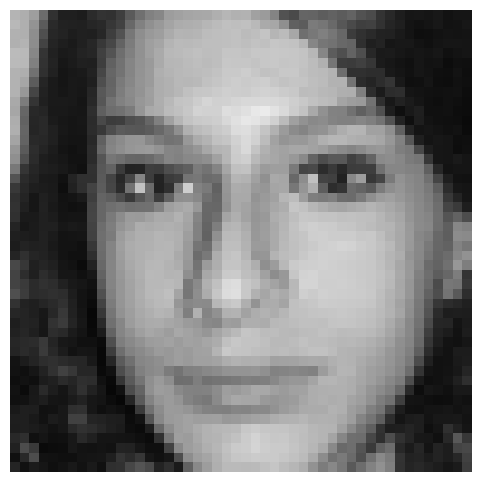

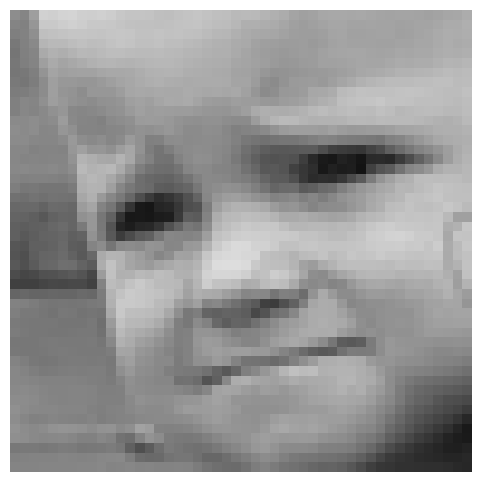

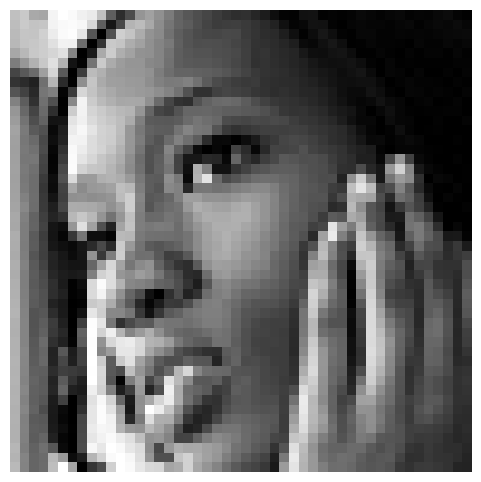

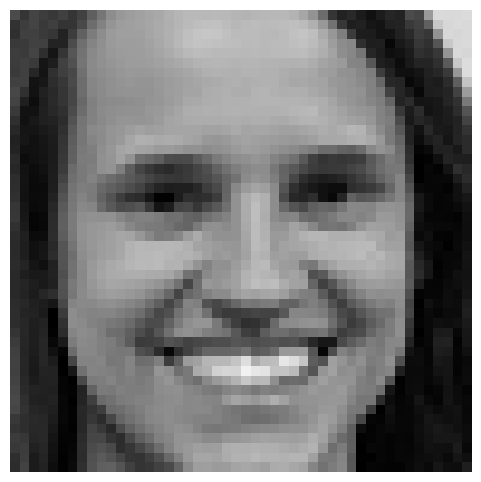

In [14]:
images = glob("dataset/train/**/**")
for i in range(11):
    image = random.choice(images)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(cv2.imread(image))
    plt.axis('off')

In [15]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("dataset/train/",
                                                    target_size=(img_size,img_size), 
                                                    color_mode= "grayscale",
                                                    batch_size=batch_size, 
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator()
train_validation = datagen_train.flow_from_directory("dataset/test/",
                                                    target_size=(img_size,img_size), 
                                                    color_mode= "grayscale",
                                                    batch_size=batch_size, 
                                                    class_mode='categorical',
                                                    shuffle=True)
                                                

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [25]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [28]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(inputs, 64, (5,5))
    conv_3 = Convolution(inputs, 12, (3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)
    output = Dense(7, activation="softmax")(dense_1)
    model= Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 12)          │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 48, 48, 12)          │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 48, 48, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6912)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,772,719 (6.76 MB)

 Trainable params: 1,772,183 (6.76 MB)

 Non-trainable params: 536 (2.09 KB)

In [37]:
epochs = 15
steps_per_epochs = train_generator.n//train_generator.batch_size
validation_steps = train_validation.n//train_validation.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor = 'val_accuracy', save_weights_only = True,
                             mode = 'max', verbose = 1)
callbacks = [checkpoint]

In [38]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epochs,
    epochs = epochs,
    validation_data = train_validation,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


C:\Users\SREERAM\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3324 - loss: 1.7930
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.3326 - loss: 1.7922 - val_accuracy: 0.4185 - val_loss: 1.5170
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5312 - loss: 1.4057
Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step - accuracy: 0.5312 - loss: 1.4057 - val_accuracy: 0.4000 - val_loss: 1.7628
Epoch 3/15


C:\Users\SREERAM\miniconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4602 - loss: 1.4187
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.4602 - loss: 1.4186 - val_accuracy: 0.4501 - val_loss: 1.4396
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5000 - loss: 1.3450
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.5000 - loss: 1.3450 - val_accuracy: 0.4000 - val_loss: 1.4265
Epoch 5/15
446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5279 - loss: 1.2596
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5278 - loss: 1.2597 - val_accuracy: 0.4681 - val_loss: 1.3831
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5781 - loss: 1.2087
Epoch 6: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.5781 - loss: 1.2087 - val_accuracy: 0.4000 - val_loss: 1.4989
Epoch 7/15
446/448 

In [39]:
model.evaluate(train_validation)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4577 - loss: 1.5443


[1.5296714305877686, 0.4632209539413452]

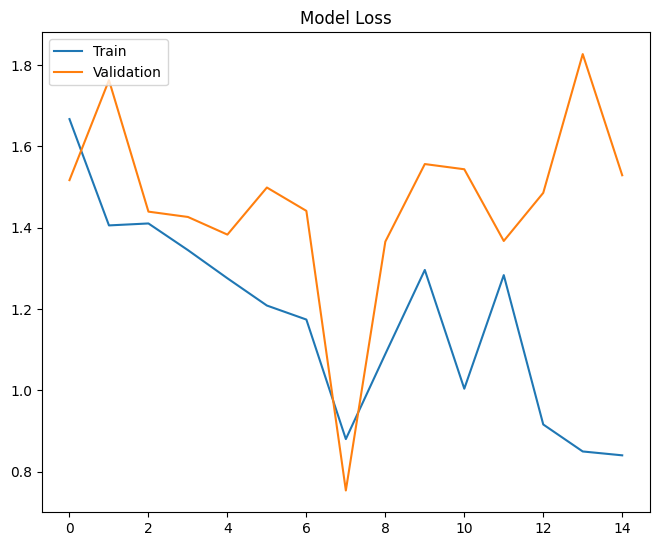

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

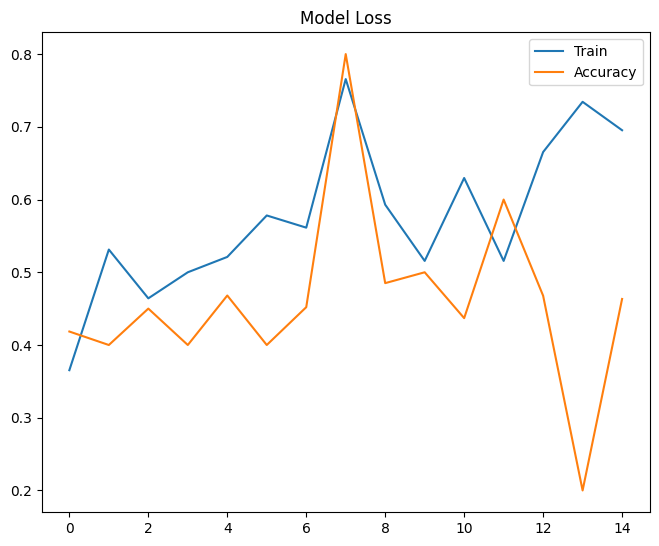

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.legend(['Train', 'Accuracy'], loc = 'upper right')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

In [44]:
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)